<a href="https://colab.research.google.com/github/msskx/deepLearning/blob/main/AQIPreForSeq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
from torch import nn

In [4]:
from matplotlib import pyplot as plt

In [5]:
df=pd.read_csv(r'/content/drive/MyDrive/时间序列/Air_AQI_yanan.csv')

In [6]:
df.tail()

,Date,Quality_grade,AQI,AQI_rank,PM2_5,PM10,SO2,NO2,CO,O3
3237,2022-12-27,良,52,95,30,53,8,39,0.98,30
3238,2022-12-28,良,56,136,33,56,12,45,1.00,23
3239,2022-12-29,优,49,96,29,52,10,44,1.07,27
3240,2022-12-30,良,67,163,45,67,12,52,1.26,26
3241,2022-12-31,良,78,171,56,78,9,55,1.27,28


In [7]:
df.columns

Index(['Date', 'Quality_grade', 'AQI', 'AQI_rank', 'PM2_5', 'PM10', 'SO2',
       'NO2', 'CO', 'O3'],
      dtype='object')

In [8]:
data=pd.DataFrame(df.loc[:,['Date','AQI', 'PM2_5', 'PM10', 'SO2','NO2', 'CO', 'O3']])

In [9]:
data=data.set_index('Date')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f827a0b6280>,
      dtype=object)

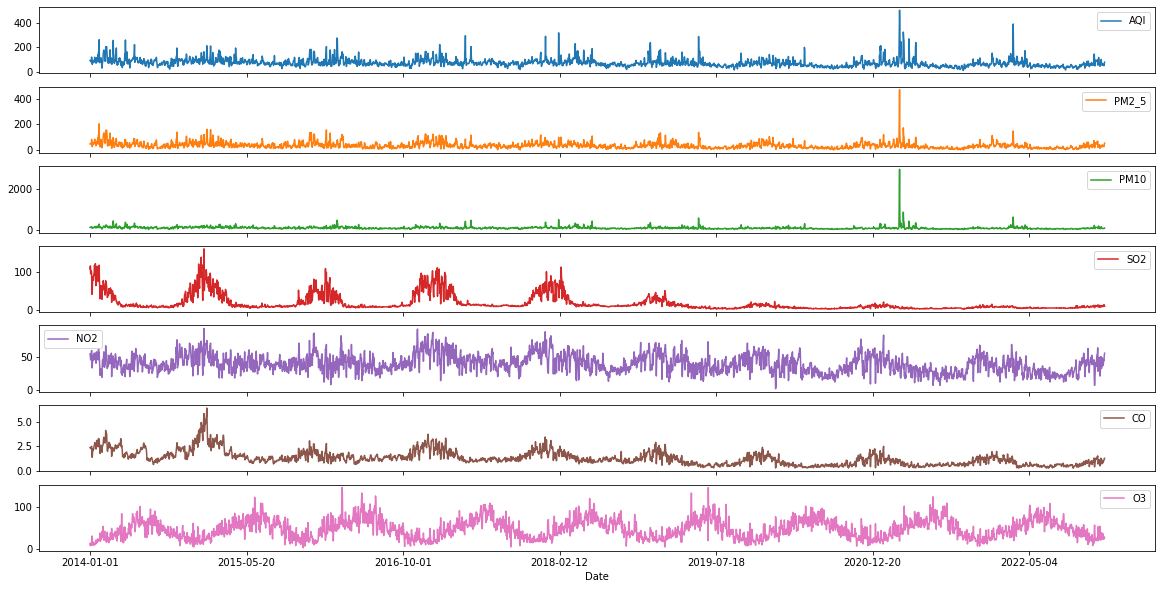

In [10]:

data.plot(subplots=True,figsize=(20,10))


In [11]:
data.head()

,AQI,PM2_5,PM10,SO2,NO2,CO,O3
Date,,,,,,,
2014-01-01,92,50,115,107,54,2.37,13
2014-01-02,87,50,106,115,50,2.34,8
2014-01-03,85,51,114,94,45,2.26,14
2014-01-04,80,49,106,97,51,2.40,12
2014-01-05,82,51,107,103,54,2.37,10


In [12]:
seq_length = 30 #观测30天
delay = 7 #预测7天

In [13]:
### 滑动窗口生成数据

In [14]:
data_=[]
for i in range(len(data) - seq_length - delay):
    data_.append(data.iloc[i:i+seq_length+delay])

In [15]:
data_[0].shape#每条训练数据有37条数据7个特征

(37, 7)

In [16]:
data_ = np.array([df.values for df in data_])

In [17]:
data_.shape

(3205, 37, 7)

In [18]:
np.random.shuffle(data_) # 乱序

In [19]:
x = data_[:,:seq_length,:] #高维切片

In [20]:
y = data_[:,-delay:,0] #取出delay个预测数据，并预测AQI特征

In [21]:
x.shape,y.shape

((3205, 30, 7), (3205, 7))

In [22]:
from sklearn.model_selection import train_test_split   

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [24]:
x_train.shape,x_test.shape

((2243, 30, 7), (962, 30, 7))

In [25]:
mean = x_train.mean(axis=0)#对列处理
std = x_train.std(axis=0)

In [26]:
x_train = (x_train-mean)/std

In [27]:
x_test = (x_test-mean)/std

In [28]:
x_train.shape

(2243, 30, 7)

In [29]:
class MYDataset(torch.utils.data.Dataset):
    def __init__(self,features,labels):
        self.features = features
        self.labels = labels
    def __getitem__(self,index):
        return self.features[index],self.labels[index]
    def __len__(self):
        return len(self.features)

In [30]:
train_ds=MYDataset(x_train,y_train)
test_ds=MYDataset(x_test,y_test)

In [31]:
train_dl=torch.utils.data.DataLoader(train_ds,batch_size=32)
test_dl=torch.utils.data.DataLoader(test_ds,batch_size=32)

In [32]:
next(iter(train_dl))[0].shape,next(iter(train_dl))[1].shape

(torch.Size([32, 30, 7]), torch.Size([32, 7]))

In [33]:
# 创建模型

In [34]:
INPUT_SIZE = x_train.shape[-1]
HIDDEN_SIZE = 64

In [35]:
INPUT_SIZE

7

In [36]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.rnn=nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers= 1,
            batch_first=True
        )
    def forward(self,x):
        r_out, (hidden,cell) = self.rnn(x)
        print(r_out.shape)
        return r_out,hidden,cell


In [37]:
class Decoder (nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.rnn=nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers= 1,
            batch_first=True
        )
        self.out=nn.Linear(HIDDEN_SIZE,7)
    def forward(self,x,hidden,cell):
        print("x:", x.shape)
        output, (hidden,cell) = self.rnn(x,(hidden,cell))
        print("output:", output.shape)
        print("output.squeeze(0):", output.squeeze(0).shape)
        prediction = self.out(output.squeeze(0))
        print("prediction:",prediction.shape)
        return  prediction,hidden,cell


In [38]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def attention_net(self, lstm_output, final_state):

        hidden = final_state.view(-1, HIDDEN_SIZE , 1) # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        # print("----------------------------------------------------")
        # print("hidden的值:", hidden.shape)
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        # print("attn_weights的值:", attn_weights.shape)
        soft_attn_weights = torch.softmax(attn_weights, 1)
        # print("soft_attn_weights的值:", soft_attn_weights.shape)
        # print("soft_attn_weights.unsqueeze(2)的值:", soft_attn_weights.unsqueeze(2).shape)
        # print("torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2))的值:", torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).shape)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        print("context的值:", context.shape)
        return context, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self,src):

        src_len=src.shape[0]
        batch_size = src.shape[1]
        outputs =torch.zeros(src_len, batch_size, 1).to(self.device).double()
        # print("------------------------------")
        # print("outputs:",outputs.shape)
        print(src.shape)
        r_out,hidden,cell = self.encoder(src)

        print("r_out",r_out.shape)
        print("hidden", hidden.shape)

        attn_output, attention = self.attention_net(r_out, hidden)
        hidden = attn_output.view(1, -1, HIDDEN_SIZE)

        for t in range(1,batch_size):
            input=src[:,t-1,:].unsqueeze(1)
            print("input:",input.shape)
            output, hidden, cell = self.decoder(input, hidden, cell)
            print("------------------------------")
            print("output:",output.shape)
            print("hidden:",  hidden.shape)
            print("cell:", cell.shape)
            print("outputs:", outputs.shape)
            print("outputs[:,t,:]:", outputs[:,t-1,:].unsqueeze(1).shape)
            outputs[:,t-1,:]=output.squeeze(1)
        print("------------------------------")
        print("outputs:",outputs.shape)
        return outputs

In [39]:
encoder=Encoder()
decoder=Decoder()
device='cpu'

In [40]:
model = Seq2Seq(encoder,decoder,device)

In [41]:
model

Seq2Seq(
  (encoder): Encoder(
    (rnn): LSTM(7, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): LSTM(7, 64, batch_first=True)
    (out): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [42]:
loss_fn = nn.MSELoss()

In [43]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [44]:
def fit(epoch, model, trainloader, testloader):
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        # x = x.float()
        x = x.to(torch.float64)
        y = y.to(torch.float64)
        y_pred = model(x)
        y_pred = y_pred.to(torch.float64)

        loss = loss_fn(y_pred, y)
        # print(type(y_pred))
        # print(type(y))
        # print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            total += y.size(0)
            running_loss += loss.item()
#    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
        
        
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
   
            x = x.to(torch.float64)
            y = y.to(torch.float64)
            y_pred = model(x)
            y_pred = y_pred.to(torch.float64)

            loss = loss_fn(y_pred, y)
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'test_loss： ', round(epoch_test_loss, 3),
             )
        
    return epoch_loss, epoch_test_loss

In [45]:

epochs = 1000

In [46]:
xx,yy=next(iter(test_dl))

In [48]:
xx.shape,yy.shape

(torch.Size([32, 30, 7]), torch.Size([32, 7]))

In [49]:
model

Seq2Seq(
  (encoder): Encoder(
    (rnn): LSTM(7, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): LSTM(7, 64, batch_first=True)
    (out): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [50]:
model(xx)

torch.Size([32, 30, 7])


RuntimeError: ignored

In [46]:
train_loss = []
test_loss = []

for epoch in range(epochs):
    epoch_loss, epoch_test_loss = fit(epoch,
                                      model,
                                      train_dl,
                                      test_dl)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)

torch.Size([32, 30, 7])


RuntimeError: ignored